In [2]:

import os
import random
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask.bag as db
from pathlib import Path
from collections import Counter
from PIL import Image
import os 
import cv2

WSIROI_PATH = "/Users/amalahmadinurov/Desktop/BP/tissue-cells/"

paths = [path.parts[-2:] for path in Path(WSIROI_PATH).rglob('*.*')]

In [3]:
df = pd.DataFrame(data=paths, columns=['Class','Images'])
df.drop(df.index[0], inplace=True)
df = df.sort_values('Class',ascending=True)
df.reset_index(drop=True, inplace=True)

In [4]:
df

Class                                             Images
0     images  TCGA-A7-A4SE-01Z-00-DX1.16BC8401-E40E-4A1A-9BD...
1     images  TCGA-GM-A2DF-01Z-00-DX1.CD0BE6D7-2DB3-4193-84C...
2     images  TCGA-C8-A27B-01Z-00-DX1.5A8A14E8-6430-4147-9C7...
3     images  TCGA-OL-A66P-01Z-00-DX1.5ADD0D6D-37C6-4BC9-8C2...
4     images  TCGA-BH-A0B9-01Z-00-DX1.c23adb4c-52d4-4dfd-b8e...
...      ...                                                ...
3754   masks  TCGA-BH-A0AV-01Z-00-DX1.5A686DA4-A29D-4BA7-9BC...
3755   masks  TCGA-BH-A1F6-01Z-00-DX1.E83F0DC0-EA2C-4641-81B...
3756   masks  TCGA-A7-A6VV-01Z-00-DX1.07AE0E16-A883-4C86-BC7...
3757   masks  TCGA-BH-A0B9-01Z-00-DX1.c23adb4c-52d4-4dfd-b8e...
3758   masks  TCGA-BH-A18G-01Z-00-DX1.DB2B5819-CE83-4E07-BD0...

[3759 rows x 2 columns]

In [5]:
df.describe()

Class                                             Images
count     3759                                               3759
unique       2                                               1880
top     images  TCGA-A7-A4SE-01Z-00-DX1.16BC8401-E40E-4A1A-9BD...
freq      1880                                                  2

In [6]:
df['Class'].value_counts()

Class
images    1880
masks     1879
Name: count, dtype: int64

In [7]:
directories = {
    "images": WSIROI_PATH + "images/",
    "masks": WSIROI_PATH + "masks/",
}


def get_dimensions_images(file):
    image = Image.open(file)
    arr = np.array(image)
    height, width, dims = arr.shape
    return height, width
    
def get_dimensions_masks(file):
    image = Image.open(file)
    arr = np.array(image)
    height, width = arr.shape
    return height, width

In [25]:
classes_names = ["underfined", "invasive tumor", "tumor-associated stroma", "in-situ tumor", "healthy glands", "necrosis not in-situ", "inflamed stroma", "rest"]


In [ ]:
MASKS_PATH = os.path.join(WSIROI_PATH, "masks")
IMAGES_PATH = os.path.join(WSIROI_PATH, "images")

In [85]:
files = [f for f in os.listdir(IMAGES_PATH) if f != ".DS_Store"]
print("Total amount of images:",len(files))

Total amount of images: 1879


In [86]:
small_c = 0
big_c = 0
for filename in files:
    img = cv2.imread(os.path.join(IMAGES_PATH, filename))
    if img.shape[0] > 1000:
        big_c+=1
    else:
        small_c+=1

In [89]:
print(f"Small image:{small_c} Big images:{big_c}")

Small image:1748 Big images:131


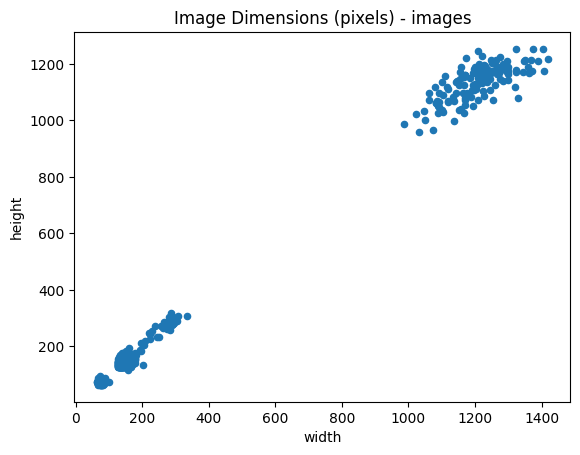

In [26]:
for label, directory in directories.items():
    
    filepath = directory
    filelist = [os.path.join(filepath, f) for f in os.listdir(filepath) if f != '.DS_Store']
    
    if label == "images":
        dims = db.from_sequence(filelist).map(get_dimensions_images)
    elif label == "masks":
        dims = db.from_sequence(filelist).map(get_dimensions_masks)
        
    dims = dims.compute()
    dim_df = pd.DataFrame(dims, columns=['height', 'width'])
    sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
    sizes.plot.scatter(x='width', y='height');
    plt.title('Image Dimensions (pixels) - {}'.format(label))
    break

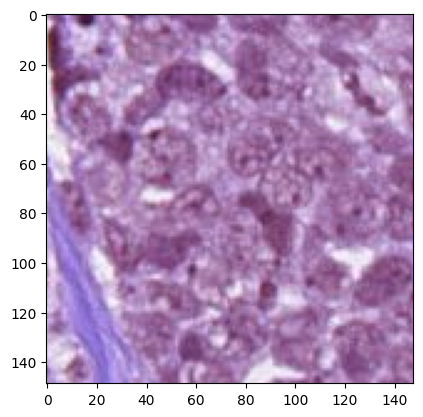

In [36]:
image_paths = os.listdir(IMAGES_PATH)
img = cv2.imread(os.path.join(IMAGES_PATH,image_paths[random.randint(0,16)]))

plt.imshow(img)

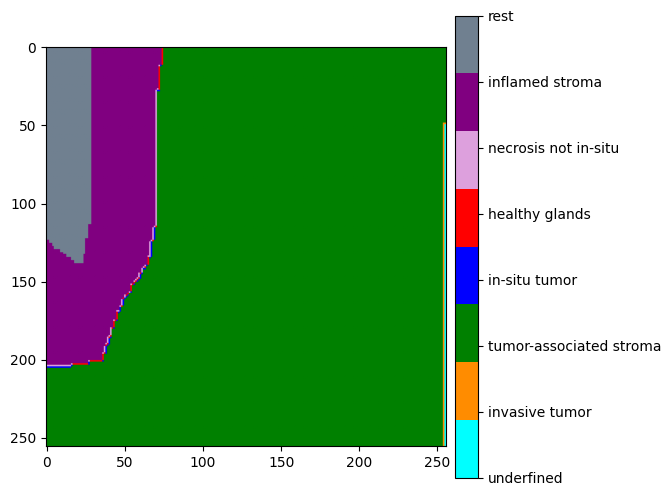

In [80]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import cv2
import os
import random

image_paths = os.listdir(IMAGES_PATH)
mask = cv2.imread(os.path.join(MASKS_PATH, image_paths[random.randint(0,len(image_paths))]), cv2.IMREAD_GRAYSCALE)
mask = cv2.resize(mask, (256, 256))

cmap = ListedColormap([
    'cyan', 'darkorange', 'green', 'blue', 'red',
    'plum', 'purple', 'slategrey'
])

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(mask, cmap=cmap)

# Add colorbar with wider fraction
cbar = plt.colorbar(im, ax=ax, fraction=0.12, pad=0.02)  # increased fraction for thicker colorbar
cbar.set_ticks(range(8))
cbar.set_ticklabels(classes_names)

plt.show()


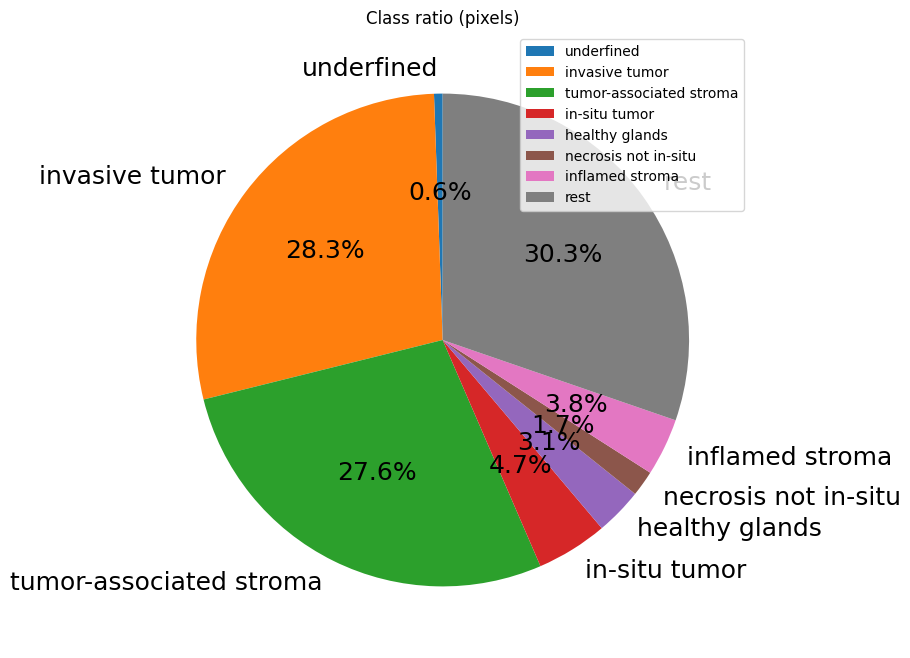

In [ ]:
import os 



unique_lbls = [0,1,2,3,4,5,6,7]
unique_lbls_counts = []
classes_counts = {}
for class_lbl in unique_lbls:
    classes_counts[class_lbl] = 0

label_pixel_count = 0
for filename in os.listdir(MASKS_PATH):
    if filename.startswith("."):
        continue
    img = cv2.imread(os.path.join(MASKS_PATH, filename))
    unique_lbls_counts.append(len(list(np.unique(img))))

    unique, counts = np.unique(img, return_counts=True)
    for idx, count in enumerate(counts):
        classes_counts[int(unique[idx])] += int(count)



counts = classes_counts.values()


plt.figure(figsize=(8, 8), dpi=100)
plt.pie(counts, labels=classes_names,autopct='%1.1f%%',  # shows percentage and the raw number
    startangle=90, textprops={'fontsize': 18}   )
plt.legend(loc="best")





plt.title("Class ratio (pixels)")


plt.show()

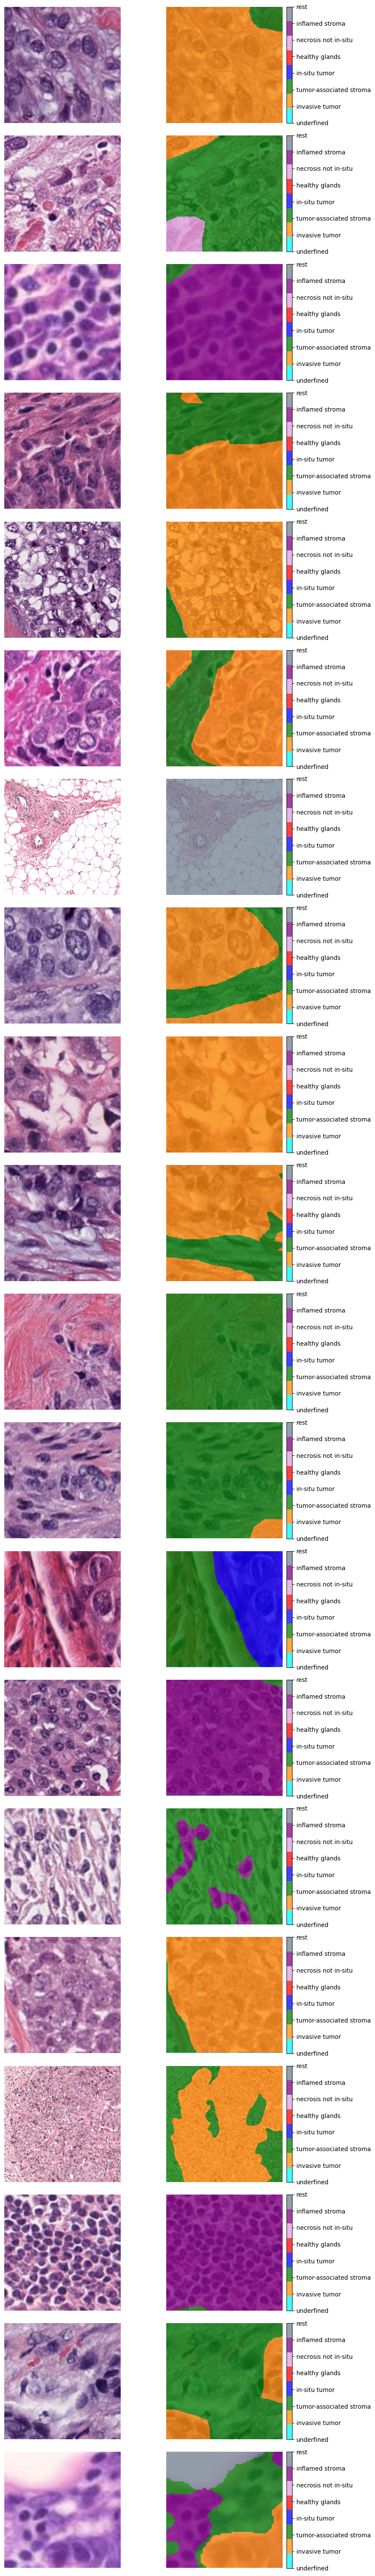

In [81]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

N_SAMPLES = 20
classes_names = [
    "underfined",
    "invasive tumor",
    "tumor-associated stroma",
    "in-situ tumor",
    "healthy glands",
    "necrosis not in-situ",
    "inflamed stroma",
    "rest"
]

IMG_SIZE = (256,256)

# Your label colormap
cmap = ListedColormap([
    'cyan', 'darkorange', 'green', 'blue', 'red',
    'plum', 'purple', 'slategrey'
])

fig, axes = plt.subplots(N_SAMPLES, 2, figsize=(10, 60))

for idx, filename in enumerate(os.listdir(IMAGES_PATH)):
    if idx >= N_SAMPLES:
        break

    # Load image
    img = cv2.imread(os.path.join(IMAGES_PATH, filename))
 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)

    # Load mask
    mask = cv2.imread(os.path.join(MASKS_PATH, filename), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, IMG_SIZE, interpolation=cv2.INTER_NEAREST)

    # Show original image
    axes[idx][0].imshow(img)
    axes[idx][0].axis("off")

    # Show mask overlay
    axes[idx][1].imshow(img)
    mappable = axes[idx][1].imshow(
        mask, cmap=cmap, alpha=0.75, vmin=0, vmax=7
    )
    axes[idx][1].axis("off")

    # Add a colorbar for this image only
    cbar = fig.colorbar(
        mappable,
        ax=axes[idx][1],
        fraction=0.05,   # size
        pad=0.02          # distance from mask
    )

    cbar.set_ticks(range(8))
    cbar.set_ticklabels(classes_names)

plt.tight_layout()
plt.show()
